_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Maria Elisabeth Dirnberger, Akseli Ilmanen, Caroline Grießhaber

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 2

## Introduction

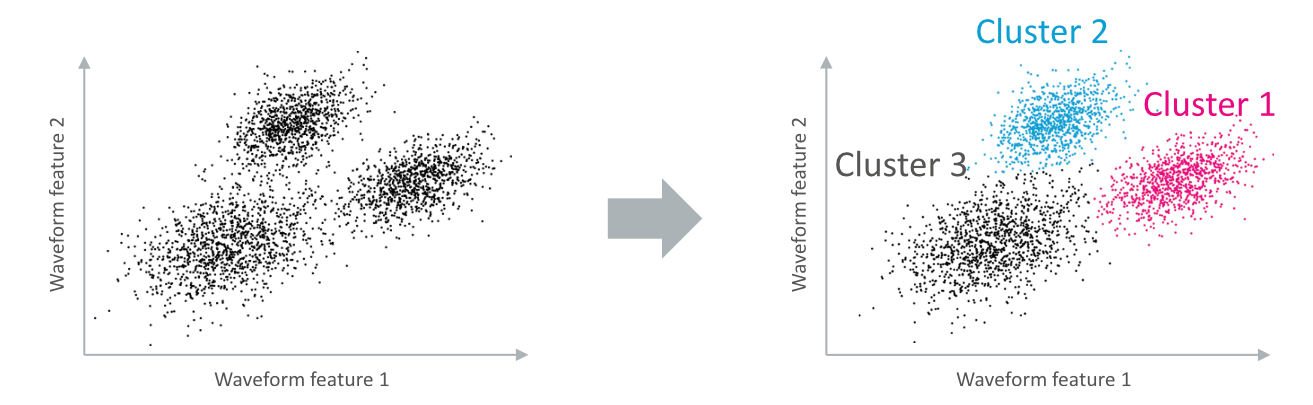

In this coding lab, we continue with the data from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-03 15:31:33W. Europe Summer Time

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

scipy     : 1.15.2
sklearn   : 1.6.1
matplotlib: 3.10.1
numpy     : 2.2.4

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

In [4]:
import os

print("Current working directory:", os.getcwd())

Current working directory: c:\Users\aksel\OneDrive\03 Tübingen\Semester 4\Neural Data Science\NDS_homework\notebooks


In [5]:
import os

print("Working directory:", os.getcwd())
print("Files in ../data:", os.listdir("../data"))

Working directory: c:\Users\aksel\OneDrive\03 Tübingen\Semester 4\Neural Data Science\NDS_homework\notebooks
Files in ../data: ['nds_cl_1.csv', 'nds_cl_1_features.npy', 'nds_cl_1_spiketimes_s.npy', 'nds_cl_1_spiketimes_t.npy', 'nds_cl_1_waveforms.npy']


## Load data

In [6]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [7]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------

    # assess number of clusters and dimension
    n_clusters = len(p)
    n_dims = m.shape[1]

    # randomly assign cluster label to each sample based on prior probabilities
    labels = rng.choice(n_clusters, size=n_samples, p=p)

    # empty list to store data points that are generated in the next line
    data_points = []

    # for each sample, generate a new data point based on the samples cluster label
    for label in labels:
        # samples data point from corresponding Gaussian distribution
        data_points.append(rng.multivariate_normal(m[label], S[label]))

    # convert list into array
    x = np.array(data_points)

    return labels, x

In [8]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

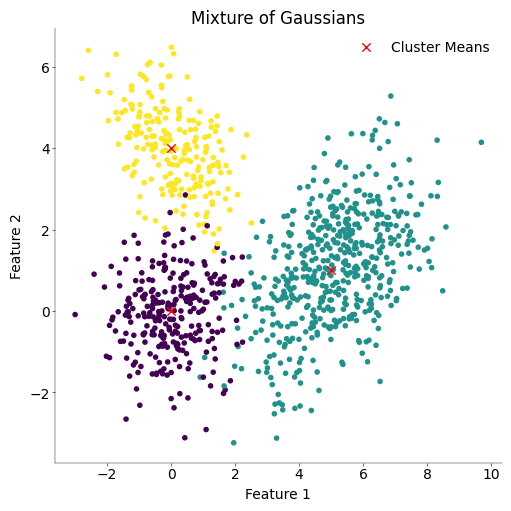

In [9]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

# scatter plot of points, colored by label
scatter = ax.scatter(x[:, 0], x[:, 1], c=labels)
# plot cluster means
ax.scatter(m[:, 0], m[:, 1], c="red", marker="x", label="Cluster Means")

# set labels and title
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Mixture of Gaussians")

ax.legend()

plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [10]:
from scipy.stats import multivariate_normal

In [ ]:
def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # -----------
    # init (1 pt)
    # -----------

    n_samples, n_dims = x.shape

    # Initialization of parameters
    S = np.array([np.cov(x.T)] * n_clusters)  # global covariance
    p = np.ones(n_clusters) / n_clusters  # uniform probability between clusters

    if init == "random":

        # randomly initialize means and covariances
        indeces = rng.choice(n_samples, n_clusters, replace=False)
        m = x[indeces]  # random means from data points

    elif init == "kmeans":

        # initialize using kmaans
        kmeans = KMeans(n_clusters=n_clusters, random_state=None).fit(x)
        ind = kmeans.labels_
        m = kmeans.cluster_centers_

    else:
        raise ValueError("Init not known")

    # -------------------------
    # EM maximisation (3 pts)
    # -------------------------

    for step in range(n_iters):

        # E step - probability that each sample belongs to a cluster
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`
        responsibilities = np.zeros((n_samples, n_clusters))
        for cluster in range(n_clusters):
            responsibilities[:, cluster] = p[cluster] * multivariate_normal.pdf(
                x, mean=m[cluster], cov=S[cluster]
            )
        # normalize responsibilities to sum to 1 for each sample
        responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

        # M step
        # Estimate new `m`, `S` and `p`
        for cluster in range(n_clusters):
            # update means
            m[cluster] = (responsibilities[:, cluster][:, np.newaxis] * x).sum(
                axis=0
            ) / responsibilities[:, cluster].sum()

        for cluster in range(n_clusters):
            # update covariances
            diff = x - m[cluster]
            S[cluster] = (
                (responsibilities[:, cluster][:, np.newaxis] * diff).T @ diff
            ).sum(axis=0) / responsibilities[:, cluster].sum()
        # Update priors
        p = responsibilities.mean(axis=0)

        # assign labels to each sample based on highest responsibility
        labels = responsibilities.argmax(axis=1)

        return labels, m, S, p

Run Mixture of Gaussian on toy data

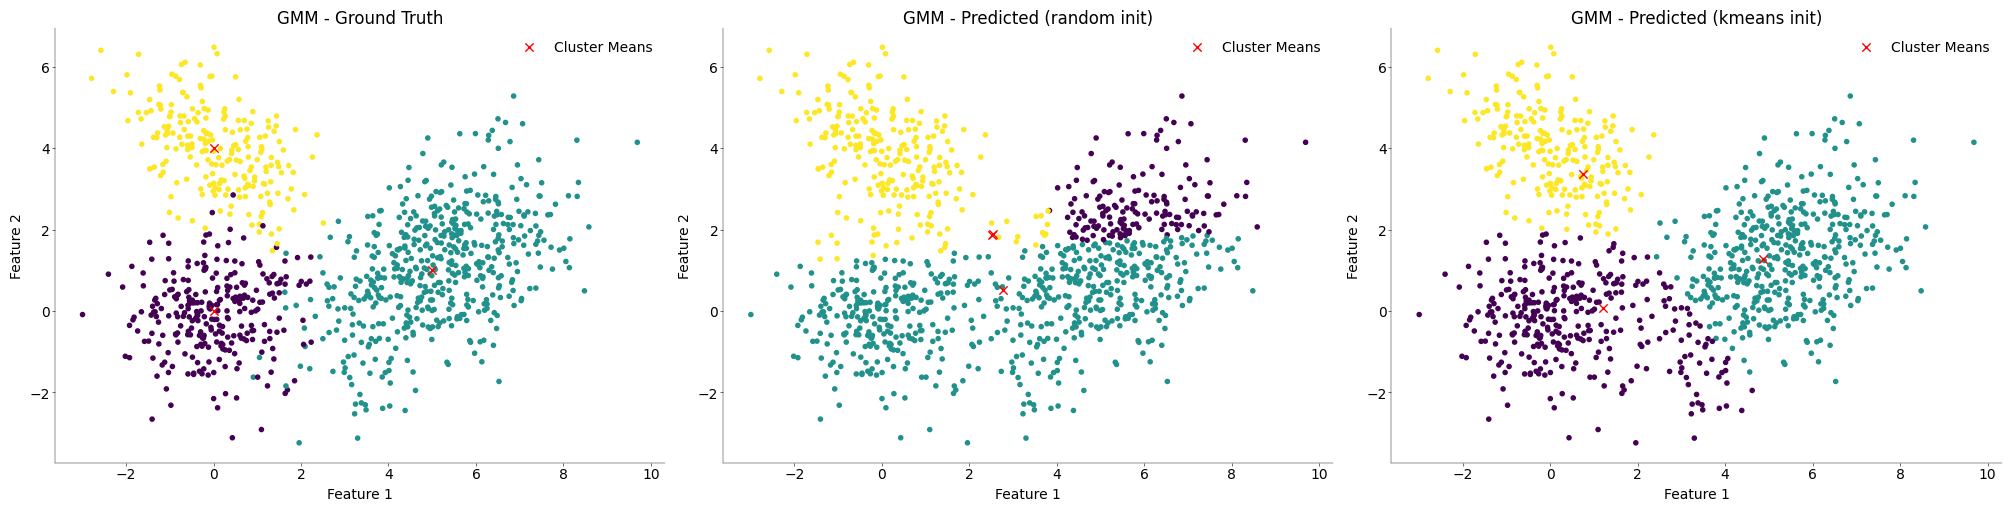

In [23]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------

n_clusters = 3


# Plot predicted clusters
fig, ax = plt.subplots(1, 3, figsize=(20, 5), layout="constrained")


# scatter plot of points, colored by Ground Truth label
ax[0].scatter(x[:, 0], x[:, 1], c=labels)
# plot cluster means
ax[0].scatter(m[:, 0], m[:, 1], c="red", marker="x", label="Cluster Means")

# set labels and title
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].set_title("GMM - Ground Truth")

ax[0].legend()


labels_pred, m_pred, S_pred, p_pred = fit_mog(
    x, n_clusters, n_iters=5, random_seed=0, init="random"
)

# Scatter plot of points colored by predicted labels
ax[1].scatter(x[:, 0], x[:, 1], c=labels_pred)
# plot predicted cluster means
ax[1].scatter(m_pred[:, 0], m_pred[:, 1], c="red", marker="x", label="Cluster Means")

# set labels and title
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Feature 2")
ax[1].set_title("GMM - Predicted (random init)")

ax[1].legend()


# Same as above with kmeans initialization

labels_pred, m_pred, S_pred, p_pred = fit_mog(
    x, n_clusters, n_iters=5, random_seed=0, init="kmeans"
)

ax[2].scatter(x[:, 0], x[:, 1], c=labels_pred)
ax[2].scatter(m_pred[:, 0], m_pred[:, 1], c="red", marker="x", label="Cluster Means")


ax[2].set_xlabel("Feature 1")
ax[2].set_ylabel("Feature 2")
ax[2].set_title("GMM - Predicted (kmeans init)")

ax[2].legend()

plt.show()

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?

_YOUR ANSWER HERE_

2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

_YOUR ANSWER HERE_

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [ ]:
# YOUR CODE HERE

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*



### Question (0.5 pts)

1) What is the number of parameters of the model?

$P = \dots$

In [18]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    # access n_clusters and n_samples
    n_clusters = p.shape[0]
    n_samples, n_dims = x.shape

    # define the number of params of a GMM for the calculation of the LL and the BIC
    # total mean params = n_clusters * n_dims
    # covariance parameters = n_clusters * (n_dims * (n_dims + 1) / 2)
    # priors = (n_clusters - 1)
    n_params = (
        (n_dims * n_clusters)
        + (n_clusters * n_dims * (n_dims + 1) / 2)
        + (n_clusters - 1)
    )

    # define the log-likelihood
    LL = np.sum(
        [
            np.log(
                np.sum(
                    [
                        p[k]
                        * sp.stats.multivariate_normal(mean=m[k], cov=S[k]).pdf(x_i)
                        for k in range(n_clusters)
                    ]
                )
            )
            for x_i in x
        ]
    )

    bic = -2 * LL + n_params * np.log(n_samples)

    return bic, LL

In [19]:
# ----------------------------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your _estimate of the BIC_ robust against local minima, regardless of the initialization strategy used (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

np.random.seed(42)

K = np.arange(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
for idx, k in enumerate(K):
    for seed in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            x, n_clusters=k, random_seed=seed, n_iters=100
        )
        BIC[seed, idx], LL[seed, idx] = mog_bic(x, mog_m, mog_S, mog_p)

ValueError: The input matrix must be symmetric positive semidefinite.

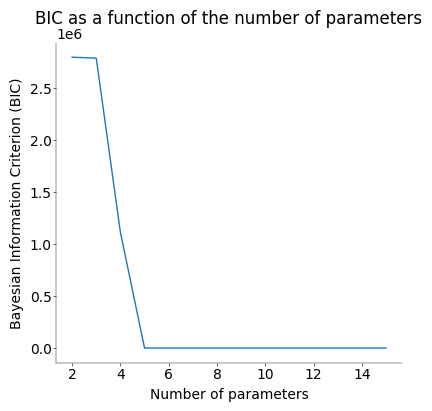

In [ ]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------

# should this be one line? -> check in with Caros code
# something seems to be off -> check with Caros code

fig, ax = plt.subplots(figsize=(4, 4))
# plot BIC

# for idx in range(BIC.shape[0]):
# plt.plot(K, BIC[idx])

mean_BIC = BIC.mean(axis=0)
plt.plot(K, mean_BIC)


plt.title("BIC as a function of the number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Bayesian Information Criterion (BIC)")
plt.show()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

_YOUR ANSWER HERE_

2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

_YOUR ANSWER HERE_

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [32]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))


for idx, k in enumerate(K):
    for seed in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(b, n_clusters=k, random_seed=seed)
        BIC[seed, idx], LL[seed, idx] = mog_bic(b, mog_m, mog_S, mog_p)

KeyboardInterrupt: 

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4))

# plot BIC
for idx in range(BIC.shape[0]):
    plt.plot(K, BIC[idx])

plt.title("BIC as a function of the number of parameters")
plt.xlabel("Number of parameters")
plt.ylabel("Bayesian Information Criterion (BIC)")
plt.show()

Refit model with lowest BIC and plot data points

In [ ]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
# a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed, init="kmeans")

In [ ]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------


## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [ ]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    





    pass

In [ ]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

_YOUR ANSWER HERE_

2) Do you see cases where plural clusters might come from the same neuron?

_YOUR ANSWER HERE_

3) Do you see clusters that might contain spikes from plural neurons?

_YOUR ANSWER HERE_

4) Explain the term "refractory period" and how one can see it in this plot.

_YOUR ANSWER HERE_